In [130]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [131]:
# Load datasets
sleep_day_data = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Sleep Fitness Data/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv')
daily_activity_data = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Sleep Fitness Data/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv')

In [132]:
# Data Cleaning
sleep_day_data.columns = sleep_day_data.columns.str.lower().str.replace(' ', '_')
daily_activity_data.columns = daily_activity_data.columns.str.lower().str.replace(' ', '_')


In [133]:
# Convert datetime columns
sleep_day_data['sleepday'] = pd.to_datetime(sleep_day_data['sleepday'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')
daily_activity_data['activitydate'] = pd.to_datetime(daily_activity_data['activitydate'], errors='coerce', format='%m/%d/%Y')


In [134]:
# Handle missing values
sleep_day_data.dropna(subset=['sleepday'], inplace=True)
daily_activity_data.dropna(subset=['activitydate'], inplace=True)


In [135]:
# Feature Engineering: Sleep Consistency
sleep_consistency = (
    sleep_day_data.groupby('id')['totalminutesasleep']
    .std()
    .reset_index()
    .rename(columns={'totalminutesasleep': 'sleep_consistency'})
)

In [136]:
# Merge Sleep Consistency with Fitness Metrics
merged_data = pd.merge(daily_activity_data, sleep_consistency, on='id', how='inner')


In [137]:
# Correlation Analysis
correlation_matrix = merged_data.corr(method='pearson')

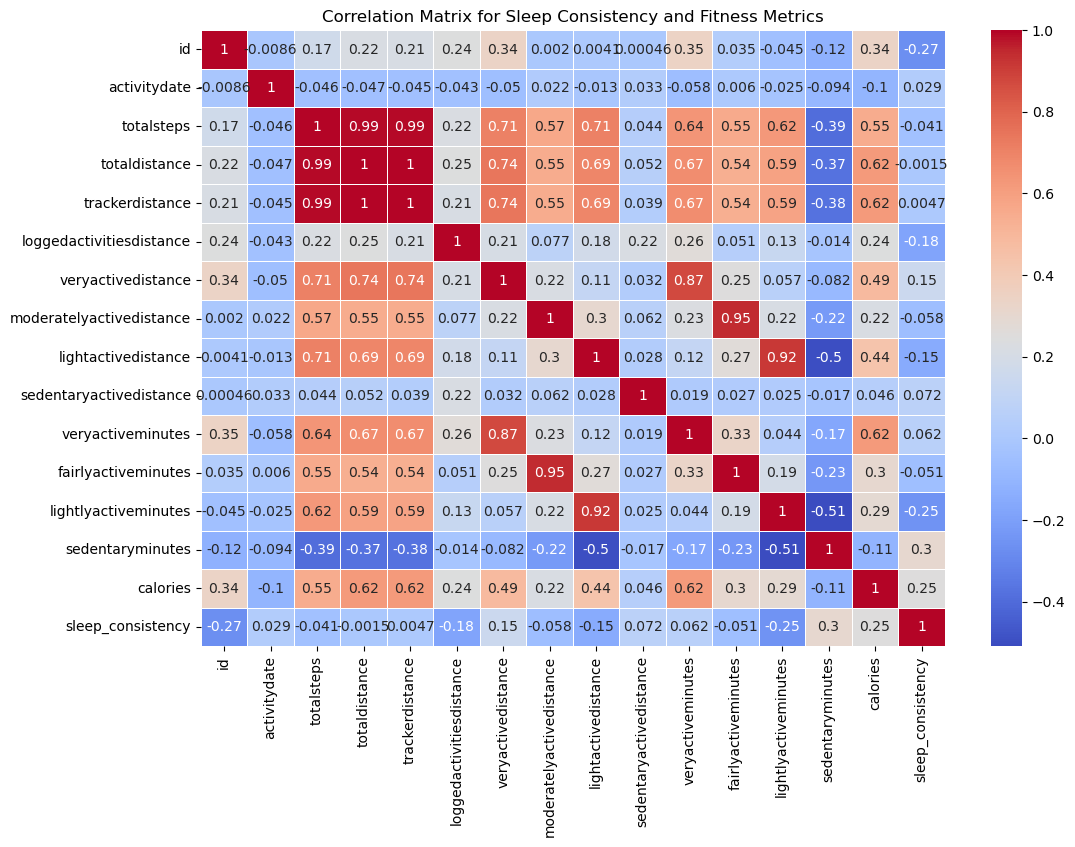

In [138]:
# Visualize Correlations with Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Sleep Consistency and Fitness Metrics')
plt.show()

In [139]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Check if indices align
print("Index alignment check:", X.index.equals(y.index))


Shape of X: (682, 5)
Shape of y: (682,)
Index alignment check: True


In [140]:
# Check for empty DataFrame
if X.empty:
    raise ValueError("Feature matrix X is empty. Please check your filtering steps.")

# Check for constant columns
constant_columns = X.loc[:, (X.nunique() <= 1)].columns
if len(constant_columns) > 0:
    print(f"Constant columns detected: {constant_columns}")
    X = X.drop(columns=constant_columns)

# Check for numerical columns
numerical_columns = X.select_dtypes(include=[np.number]).columns
if len(numerical_columns) != X.shape[1]:
    print(f"Non-numeric columns found: {set(X.columns) - set(numerical_columns)}")
    X = X[numerical_columns]


In [141]:
if y.isnull().any():
    print("Missing values detected in y. Dropping corresponding rows.")
    y = y.dropna()

# Align X and y
X, y = X.align(y, join='inner', axis=0)
print(f"Aligned shapes - X: {X.shape}, y: {y.shape}")


Aligned shapes - X: (682, 5), y: (682,)


In [142]:
correlation_matrix = X.corr()
if correlation_matrix.isnull().values.all():
    print("Correlation matrix contains only NaN values. Please check your data.")
else:
    print("Correlation matrix successfully calculated.")


Correlation matrix successfully calculated.


In [143]:
if X.isnull().any().any() or y.isnull().any():
    print("Missing or invalid values detected. Cleaning data.")
    X = X.dropna()
    y = y.dropna()

# Check for infinite values
if np.isinf(X).values.any():
    print("Infinite values detected in X. Removing rows with infinite values.")
    X = X.replace([np.inf, -np.inf], np.nan).dropna()

if np.isinf(y).values.any():
    print("Infinite values detected in y. Removing rows with infinite values.")
    y = y.replace([np.inf, -np.inf], np.nan).dropna()


In [144]:
print(f"Final shape of X: {X.shape}")
print(f"Final shape of y: {y.shape}")
if X.shape[0] == 0 or X.shape[1] == 0 or y.shape[0] == 0:
    raise ValueError("After cleaning, X or y is empty. Please debug the filtering steps.")


Final shape of X: (682, 5)
Final shape of y: (682,)


In [145]:
if X.shape[0] <= X.shape[1]:
    print("Insufficient samples for the number of predictors. Consider reducing the number of features.")


In [146]:
print("Data types of X:\n", X.dtypes)
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
if not non_numeric_columns.empty:
    print(f"Non-numeric columns detected: {non_numeric_columns}")
    X = X.select_dtypes(include=[np.number])


Data types of X:
 totalsteps                    int64
veryactiveminutes             int64
calories                      int64
lightactivedistance         float64
moderatelyactivedistance    float64
dtype: object


In [147]:
# Multiple Linear Regression
model = sm.OLS(y, X).fit()
print(model.summary())

# Non-linear Model: Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)
y_pred = rf_model.predict(X)

                                 OLS Regression Results                                
Dep. Variable:      sleep_consistency   R-squared (uncentered):                   0.758
Model:                            OLS   Adj. R-squared (uncentered):              0.757
Method:                 Least Squares   F-statistic:                              424.9
Date:                Sat, 21 Dec 2024   Prob (F-statistic):                   5.08e-206
Time:                        10:20:06   Log-Likelihood:                         -3776.4
No. Observations:                 682   AIC:                                      7563.
Df Residuals:                     677   BIC:                                      7585.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [148]:
# Add constant column back for regression
X = sm.add_constant(X)

In [149]:
# Evaluate Random Forest Model
print("Random Forest Regression:")
print("Mean Squared Error:", mean_squared_error(y, y_pred))
print("R-squared:", r2_score(y, y_pred))

Random Forest Regression:
Mean Squared Error: 478.6593716542578
R-squared: 0.9018221515154966


In [150]:
# Regression Analysis
features = ['totalsteps', 'veryactiveminutes', 'calories', 'lightactivedistance', 'moderatelyactivedistance']
X = merged_data[features]
y = merged_data['sleep_consistency']

In [151]:
# Identify missing values in y
print("Number of NaN values in y before handling:", y.isnull().sum())

# Drop rows with NaN in y
X = X[~y.isnull()]
y = y[~y.isnull()]

# Verify no NaN values remain in y
assert not y.isnull().any(), "y still contains NaN values!"

# Optional: Remove rows with missing values in X (if applicable)
X.dropna(inplace=True)
assert not X.isnull().any().any(), "X contains NaN values!"

# Train the model after cleaning
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

# Get Feature Importances
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)


Number of NaN values in y before handling: 31
Feature Importances:
                    Feature  Importance
2                  calories    0.361054
0                totalsteps    0.231740
3       lightactivedistance    0.217899
4  moderatelyactivedistance    0.100373
1         veryactiveminutes    0.088934


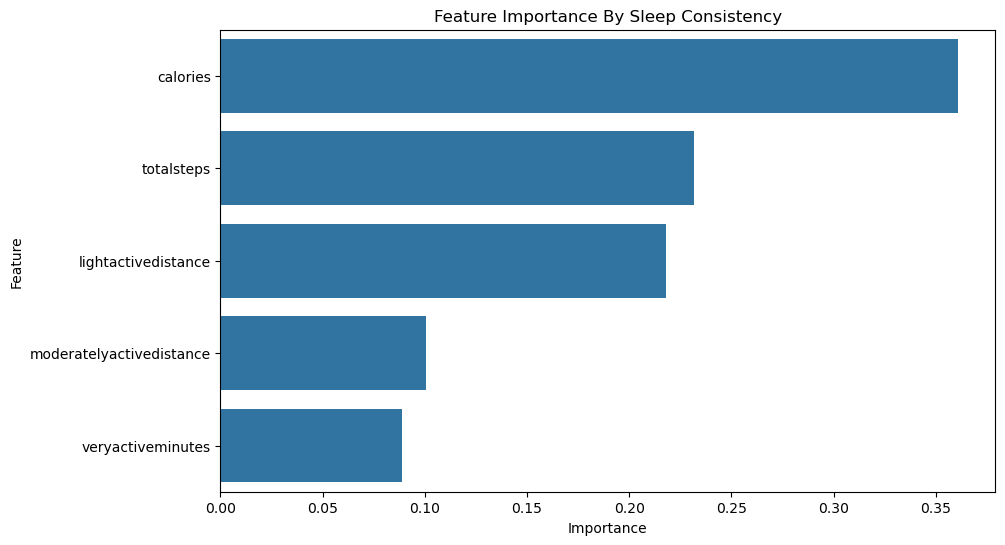

In [153]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance By Sleep Consistency')
plt.show()